Adapted from:  https://github.com/roboflow/notebooks/blob/main/notebooks/automated-dataset-annotation-and-evaluation-with-grounding-dino.ipynb

In [ ]:
!nvidia-smi

Sat Jun 22 15:13:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8" #fix for an error that sometimes appears in Colab

import os
HOME = os.getcwd()
print(HOME)

/content/GroundingDINO


In [ ]:
# Download and install Grounding DINO and roboflow
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO

# we use latest Grounding DINO model API that is not official yet
!git checkout feature/more_compact_inference_api

!pip install -q -e .
!pip install -q roboflow dataclasses-json onemetric

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 443, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 443 (delta 158), reused 139 (delta 130), pack-reused 231
Receiving objects: 100% (443/443), 12.86 MiB | 33.60 MiB/s, done.
Resolving deltas: 100% (229/229), done.
/content/GroundingDINO
Branch 'feature/more_compact_inference_api' set up to track remote branch 'feature/more_compact_inference_api' from 'origin'.
Switched to a new branch 'feature/more_compact_inference_api'
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.0 MB/s e

In [ ]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import roboflow
import supervision

print(
    "roboflow:", roboflow.__version__,
    "; supervision:", supervision.__version__
)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.3 ; cuda:  cu121
roboflow: 1.1.33 ; supervision: 0.4.0


In [ ]:
# confirm that configuration file exist

import os

CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [ ]:
# download weights file

%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

# confirm that weights file exist

import os

WEIGHTS_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/content
/content/weights
/content/weights/groundingdino_swint_ogc.pth ; exist: True


In [ ]:
from google.colab import drive
# Mount point in Colabs machine
drive.mount('/content/drive')

# Location of project in Google Drive after mounting
if "Colabs" in os.listdir("/content/drive/MyDrive"):
  fpath='/content/drive/MyDrive/Colabs/Rat_detector'
else:
  fpath='/content/drive/MyDrive/Rat_detector'

%cd {HOME}
# !mkdir -p {HOME}/data
# %cd {HOME}/data

DATA=fpath+"/data"
DATA_ANNOTATED=fpath+"/data_annotated"

# Copy rat images from Google drive to {HOME}/data
# (Could also mount)
# !cp -r {fpath}/data/* .


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [ ]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

model = Model(model_config_path=CONFIG_PATH, model_checkpoint_path=WEIGHTS_PATH)

/content/GroundingDINO
final text_encoder_type: bert-base-uncased


In [ ]:
!ls {DATA} | wc -l   # count pictures in the {DATA} directory to check if it's correctly defined

444


In [ ]:
imageNumbers = os.listdir(f"{DATA}/*.jgp")

SOURCE_IMAGE_PATH = f"{DATA}/rat_467.jpg"
CLASSES = ['rat']
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

In [ ]:
def list_image_files(directory: str):
    image_extensions = [".jpeg", ".jpg", ".png", ".bmp", ".gif"]
    image_files = [f for f in os.listdir(directory) if os.path.splitext(f)[1].lower() in image_extensions]
    return image_files


'rat_877.jpg'

### Classes Inference Mode
---
**NOTE:** You pass list of classes as a argument. Phrases returned by the model during prediction are treated as categories. For this reason, BoxAnnotator produces paint boxes with the same associated categories with the same color.

In [ ]:
import random
random.seed(42)

In [ ]:
# Find rats in 9 random images from dataset and display with annotated boxes

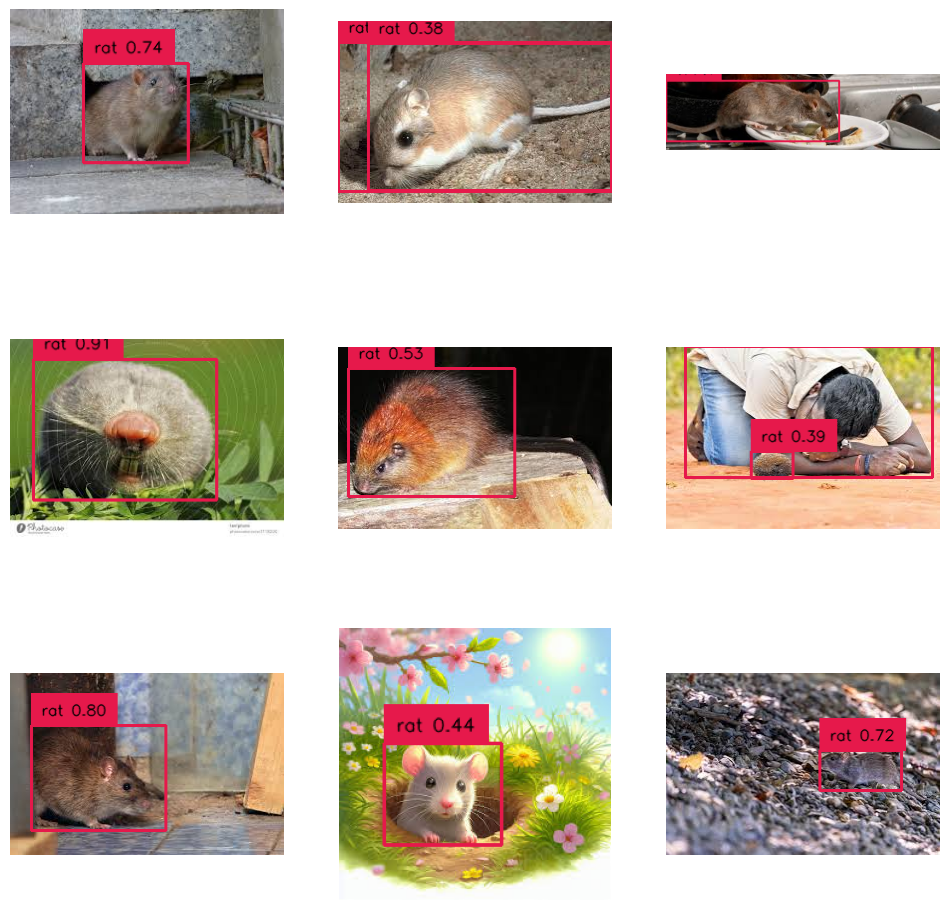

In [ ]:
import cv2
import os

import supervision as sv


%matplotlib inline

# helper function
def list_image_files(directory: str):
    image_extensions = [".jpeg", ".jpg", ".png", ".bmp", ".gif"]
    image_files = [f for f in os.listdir(directory) if os.path.splitext(f)[1].lower() in image_extensions]
    return image_files


image_list=[]
for i in range(9):

  random.choice(list_image_files(DATA))
  image = cv2.imread(f"{DATA}/{random.choice(list_image_files(DATA))}")

  detections = model.predict_with_classes(
      image=image,
      classes=CLASSES,
      box_threshold=BOX_TRESHOLD,
      text_threshold=TEXT_TRESHOLD
  )

  box_annotator = sv.BoxAnnotator()
  labels = [
      f"{CLASSES[class_id]} {confidence:0.2f}"
      for _, confidence, class_id, _
      in detections]
  image_list.append(box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels))


sv.plot_images_grid(images=image_list,grid_size=(3,3), size=(12, 12))

## Dataset auto annotation

In [ ]:

# Some helper functions
import os


def save_voc_xml(xml_string: str, file_path: str):
    with open(file_path, 'w') as f:
        f.write(xml_string)

def image_name_to_txt_name(image_name: str):
    base_name, _ = os.path.splitext(image_name)
    txt_name = f"{base_name}.txt"
    return txt_name

from typing import List

def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

In [ ]:
!mkdir -p {annotated_imagedir}


In [ ]:
# loop through images in imagedir

from tqdm.notebook import tqdm
import glob
import numpy as np
import locale
locale.getpreferredencoding = lambda: "UTF-8"

imagedir = f"{DATA}"

# Annotated images stored in sub-directory to DATA
annotated_imagedir = f"{DATA_ANNOTATED}"
# create directory in case it does not exist

!mkdir -p {annotated_imagedir}

CLASSES = ['rat']
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_files = list_image_files(imagedir)

detections_batches = []

for image in tqdm(image_files):
    image_name = image
    image_path = os.path.join(imagedir, image_name)

    image = cv2.imread(image_path)
    h, w, _ = image.shape

    detections = model.predict_with_classes(
        image=image,
        classes=enhance_class_name(class_names=CLASSES),
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )

    # drop potential detections with phrase that is not part of CLASSES set
    detections = detections[detections.class_id != None]
    # drop potential detections with area close to area of whole image (why?)
    detections = detections[(detections.area / (h * w)) < 0.99 ]
    # drop potential double detections
    detections = detections.with_nms()

    detections_batch = np.column_stack((
        detections.xyxy,
        detections.class_id,
        detections.confidence
    ))

    detections_batches.append(detections_batch)

    # write annotations to file for each image in YOLOv10 format
    # Details see: https://roboflow.com/formats/yolov10-pytorch-txt
    with open(os.path.join(annotated_imagedir, image_name_to_txt_name(image_name)), 'w',encoding="utf8") as f:
      for ds in detections_batch:
          x1, y1, x2, y2 = ds[:4]
          #print(ds[:4])
          class_id = ds[4]
          cx= (x1+x2)/2/w
          cy= (y1+y2)/2/h
          cw= (x2-x1)/w
          ch= (y2-y1)/h
          confidence = ds[5] #not used here
          f.write(f"{int(class_id):d} {cx} {cy} {cw} {ch}\n")

    box_annotator = sv.BoxAnnotator()
    labels = [
        f"{CLASSES[class_id]} {confidence:0.2f}"
        for _, confidence, class_id, _
        in detections]
    # add annotations to image and save annotated image
    annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

    # only save annotation data in a txt file for roboflow annotation
    #cv2.imwrite(os.path.join(annotated_imagedir, image_name), annotated_frame)

# label info file for YOLOv10 annotation format
with open(os.path.join(annotated_imagedir, "data.yaml"), 'w',encoding="utf8") as f:
    f.write("nc: 1\nnames: ['rat']")

  0%|          | 0/444 [00:00<?, ?it/s]

In [ ]:
# Takes time for some files to appear in Google-drive - syncing is not instantaneous

In [ ]:
# Login for Roboflow assumes api_key is stored in Colab secrets under name: RoboKey

%cd {HOME}

import roboflow
from google.colab import userdata
from roboflow import Roboflow

roboflow.login()

# api_key stored in Secrets storage in notebook
rf = Roboflow(api_key=userdata.get('RoboKey'))


/content/GroundingDINO
You are already logged into Roboflow. To make a different login,run roboflow.login(force=True).


In [ ]:
# uploading to Roboflow project - takes a bit of time but only needs to be done once
import glob

project=rf.workspace().project("rat-detector-gdm1a")

# Directory path and file extension for images
imagedir = f"{DATA}"
annotated_imagedir = f"{DATA_ANNOTATED}"

file_extension_type = ".jpg"

# Annotation file path and format (e.g., .coco.json)
labelmap_path = f"{DATA_ANNOTATED}/data.yaml"

# Upload images to roboflow
image_glob = glob.glob(imagedir + '/*' + file_extension_type)
for image_path in image_glob:
    annotation_filename = image_path.replace(".jpg",".txt").replace(imagedir,annotated_imagedir)
    # print(image_path)
    # print(annotation_filename)
    res=project.single_upload(
        image_path=image_path,
        annotation_path=annotation_filename,
        annotation_labelmap=labelmap_path,
        num_retry_uploads=3,
    )

    if ('error' in res['image'].keys()) or ('error' in res['annotation'].keys()):
        print(image_path,res)


loading Roboflow workspace...
loading Roboflow project...
/content/drive/MyDrive/Colabs/Rat_detector/data/rat_18.jpg {'image': {'duplicate': True, 'id': 'KKK6xEmeQXzRASFkLklI'}, 'annotation': {'error': UploadError("save annotation for KKK6xEmeQXzRASFkLklI / bad response: 400: {'message': 'Image was already annotated.', 'type': 'InvalidImageException', 'hint': 'This image was already annotated; to overwrite the annotation, pass overwrite=true as a query parameter.'}")}, 'upload_time': 0.4879121780395508, 'annotation_time': 0.30501699447631836, 'upload_retry_attempts': 0}
/content/drive/MyDrive/Colabs/Rat_detector/data/rat_49.jpg {'image': {'duplicate': True, 'id': 'AnD7zYgRdAcYaIz1dZ1j'}, 'annotation': {'error': UploadError("save annotation for AnD7zYgRdAcYaIz1dZ1j / bad response: 400: {'message': 'Image was already annotated.', 'type': 'InvalidImageException', 'hint': 'This image was already annotated; to overwrite the annotation, pass overwrite=true as a query parameter.'}")}, 'upload

In [ ]:
'error' in res['image'].keys()

False

In [ ]:
# download annotated images

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ySrArunTi0VBAiQjW8CQ")
project = rf.workspace("ratscv-tuzm1").project("rat-detector-gdm1a")
version = project.version(1)
dataset = version.download("yolov9")
